In [1]:
"""
    clustering.ipynb
    Functions for implementing k-means clustering for quantizing the colors in an image.
    Mustafa Siddiqui
"""
pass

In [2]:
from inc import IP
%matplotlib inline

In [5]:
def quantizeColors(img, numColors):
    ''' Quantize image into given number of colors using k-means 
        clustering algorithm.
    '''
    
    #red = img[:, :, 0].flatten()
    #blue = img[:, :, 1].flatten()
    #green = img[:, :, 2].flatten()
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    
    return red, green, blue

In [181]:
I = IP.imread('Doyley.jpg')
IGray = IP.rgb2gray(I);
l, w = IGray.shape

In [7]:
r, g, b = quantizeColors(I, 3)
#r = IP.np.reshape(r, (l, w))
#g = IP.np.reshape(g, (l, w))
#b = IP.np.reshape(b, (l, w))

In [8]:
out = IP.np.zeros((l, w, 3), dtype='int')
out[:,:,0] = r
out[:,:,1] = g
out[:,:,2] = b

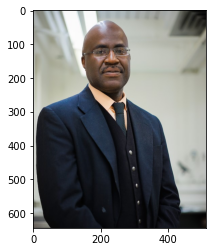

In [9]:
IP.imshow(out)

(644, 512, 3)

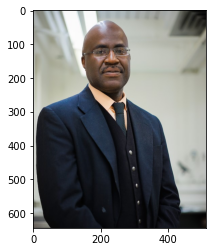

In [10]:
I2 = IP.imread('Doyley.jpg')
IP.imshow(I2)
I2.shape

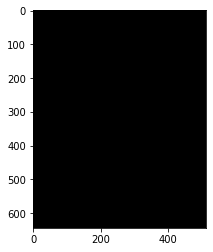

In [11]:
IP.imshow(I2-out, cmap='gray')

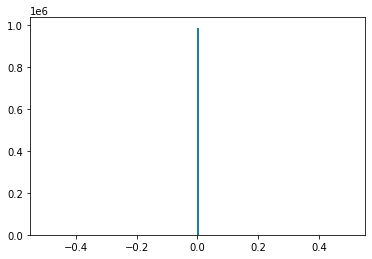

In [14]:
# confirm both images are exactly the same
dump = IP.plt.hist((I2-out).ravel(), bins=250)

In [142]:
class Color:
    ''' A class to store RGB values of a color and provide
        some simple methods.
    '''
    
    def __init__(self, red, green, blue):
        ''' Constructor for class. '''
        self.red = red
        self.green = green
        self.blue = blue
    
    def getDistance(self, anotherColor):
        ''' Returns the Euclidean distance on the RGB color cube model. '''
        redDiff = (self.red - anotherColor.red)**2
        greenDiff = (self.green - anotherColor.green)**2
        blueDiff = (self.blue - anotherColor.blue)**2
        
        return int(IP.np.sqrt(redDiff + blueDiff + greenDiff))
    
    def __str__(self):
        return "red: " + str(self.red) + ", green: " + str(self.green) + ", blue: " + str(self.blue)

In [144]:
def getColorFromPixel(img, coor):
    ''' Given a tuple of x,y coordinates (x, y), return the RGB values
        of the pixel at those coordinates in an image.
    '''
    
    red = int(img[coor[0], coor[1], 0])
    green = int(img[coor[0], coor[1], 1])
    blue = int(img[coor[0], coor[1], 2])
    
    return Color(red, green, blue)

In [143]:
def colorDistinctOrNot(color1, color2):
    ''' Helper function to check if two colors are distinct
        enough based on their euclidean distance on the RGB cube.
    '''
    
    d = color1.getDistance(color2)
    if (d > 50):
        return True
    
    return False

In [179]:
def chooseRandomColors(img, k):
    ''' Choose k random but distinct colors from the image.
        
        @return a set of k color objects
    '''
    l, w, numColors = img.shape
    
    # choose k distinct somewhat contrasting colors at random
    # first get random pixel coordinates and then obtain color
    colors = set()
    for i in range(k):
        x = IP.np.random.randint(1, l)
        y = IP.np.random.randint(1, w)
        coor = (x, y)
        color = getColorFromPixel(I, coor)
        
        distinct = False;
        while (distinct == False):
            x = IP.np.random.randint(1, l)
            y = IP.np.random.randint(1, w)
            coor = (x, y)
            color = getColorFromPixel(I, coor)
            
            # if set is not empty, check if new color is
            # somewhat distinct from colors already in set
            _distinct = True
            if (len(colors) != 0):
                for c in colors:
                    if (colorDistinctOrNot(c, color) == False):
                        # if not distinct with one, no need to check with others
                        _distinct = False
                        break

                # distinct from all colors currently stored
                if (_distinct):
                    distinct = True
            else:
                break
            
            # if color not distinct, pick another color
            if (distinct == False):
                continue
        
        # add distinct color
        colors.add(color)
        
    return colors

In [182]:
# get k random colors from image
k = 8
colorsCentroid = chooseRandomColors(I, k)
centroidList = list(colorsCentroid)

In [183]:
# create hashmap with centroids as keys and empty lists
# list for a centroid will store the colors which have the minimum difference
# with that centroid
centroidDict = {}
for c in centroidList:
    print(c)
    centroidDict[c] = []

red: 251, green: 251, blue: 251
red: 55, green: 69, blue: 104
red: 27, green: 27, blue: 39
red: 144, green: 99, blue: 80
red: 89, green: 72, blue: 62
red: 208, green: 210, blue: 205
red: 184, green: 187, blue: 166
red: 149, green: 151, blue: 146


In [184]:
changeInCentroids = True
while (changeInCentroids):
    # iterate over the image and populate centroid dictionary
    for i in range(l):
        for j in range(w):
            # get color from pixel
            pixelColor = getColorFromPixel(I, (i, j))
            
            # populate hashmap with distances between colors based on RGB cube
            distances = {}
            for centroid in centroidDict:
                if (centroid not in distances):
                    distances[centroid] = pixelColor.getDistance(centroid)
            
            # get centroid which has the lowest distance (aka color difference)
            minDiff = 9999
            minKey = Color(0,0,0)
            for key in distances:
                if distances[key] < minDiff:
                    minDiff = distances[key]
                    minKey = key
            
            # add RGB color to centroid list
            centroidDict[minKey].append(pixelColor)
            
    # get mean of red, green, blue values separately and create new
    # color object with those values and update centroid values
    redSum = 0
    greenSum = 0
    blueSum = 0
    newDict = {}
    changeInCentroids = False
    for key in centroidDict:
        for color in centroidDict[key]:
            redSum += color.red
            greenSum += color.green
            blueSum += color.blue
            
        redSum /= len(centroidDict[key])
        greenSum /= len(centroidDict[key])
        blueSum /= len(centroidDict[key])
        
        # add new centroid to new dict
        newCentroid = Color(int(redSum), int(greenSum), int(blueSum))
        newDict[newCentroid] = []
        
        # update flag if new centroid is different from prev one
        if (key.getDistance(newCentroid) > 50):
            changeInCentroids = True
        
    # replace centroid dict with new one
    centroidDict = newDict

In [185]:
for key in centroidDict:
    print(key)
    print(centroidDict[key])

red: 247, green: 248, blue: 247
[]
red: 45, green: 62, blue: 85
[]
red: 21, green: 23, blue: 30
[]
red: 130, green: 105, blue: 93
[]
red: 88, green: 73, blue: 61
[]
red: 201, green: 204, blue: 196
[]
red: 182, green: 184, blue: 174
[]
red: 152, green: 151, blue: 143
[]


In [186]:
# now we should have the ideal centroids
# we begin to update the colors in the image
for i in range(l):
    for j in range(w):
        # get color from pixel
        pixelColor = getColorFromPixel(I, (i, j))

        # populate hashmap with distances between colors based RGB cube
        distances = {}
        for centroid in centroidDict:
            if (centroid not in distances):
                distances[centroid] = pixelColor.getDistance(centroid)

        # get centroid which has the lowest distance (aka color difference)
        minDiff = 9999
        minKey = Color(0,0,0)
        for key in distances:
            if distances[key] < minDiff:
                minDiff = distances[key]
                minKey = key
        
        # update colors 
        I[i, j, 0] = minKey.red
        I[i, j, 1] = minKey.green
        I[i, j, 2] = minKey.blue

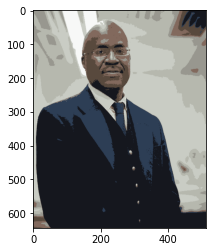

In [187]:
IP.imshow(I)